**Lab2 Part 2.** Carlos Garcia 21000475

# Tarea 2 - Regresion Polinomial & Feature engineering

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 30 de mayo. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

### Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [18]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime, date

from matplotlib import pyplot as plt
import seaborn as sns

print(tf.__version__)

2.5.0-rc3


In [19]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [20]:
data = pd.read_csv('./inputs/winequality-red.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Análisis exploratorio

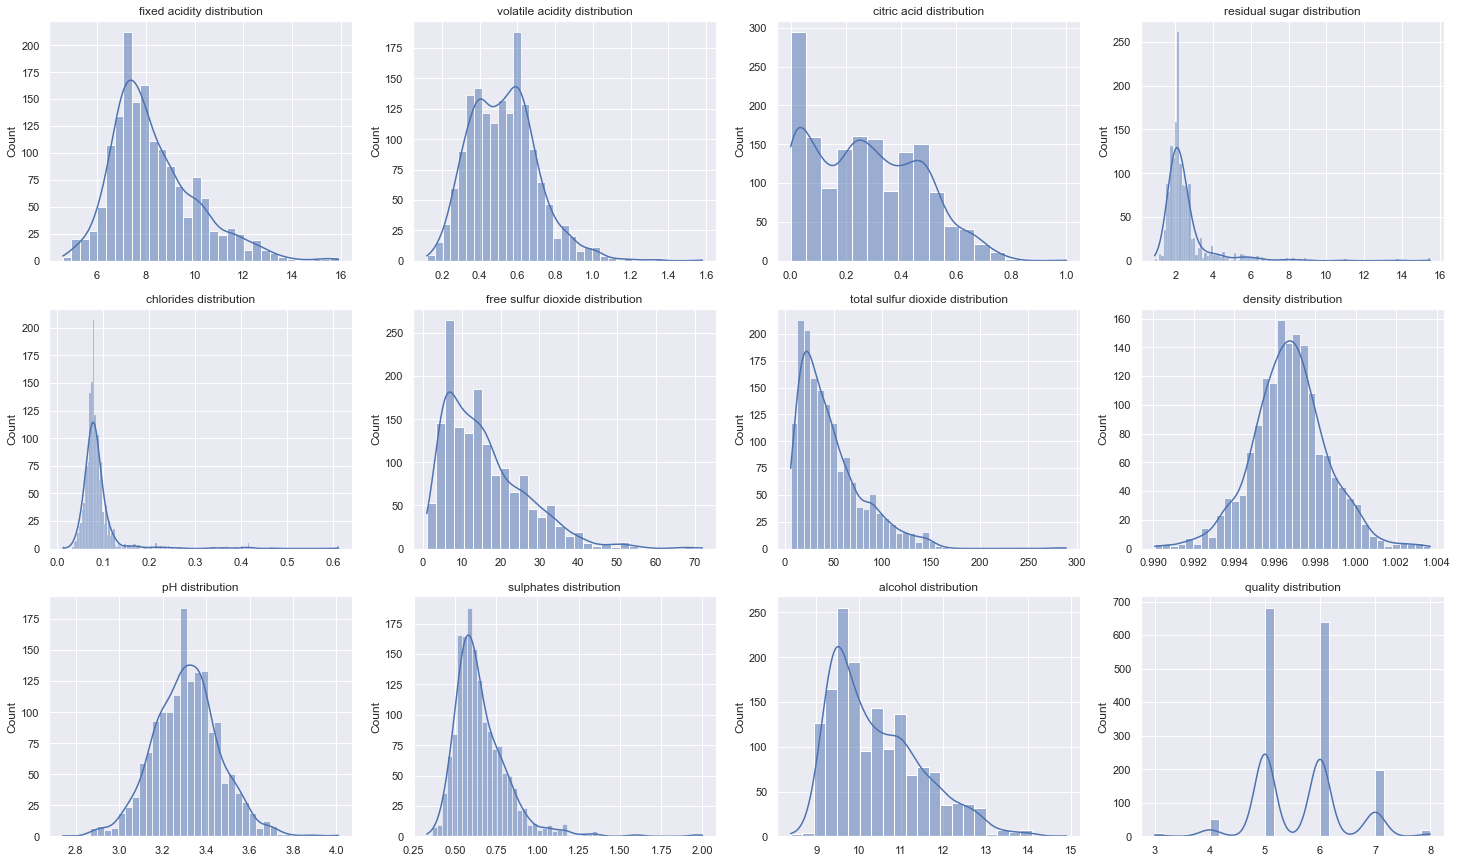

In [21]:
rows = 3
cols = 4
features = list(data.columns)

sns.set(rc={'figure.figsize': (25, 15)})
fig, ax = plt.subplots(rows, cols)

for row in range(0, rows):
    for col in range(0, cols):
        sns.histplot(data = data, x = features[col + (row * cols)], kde = True, ax = ax[row, col])
        ax[row, col].set(title = '{} distribution'.format(features[col + (row * cols)]), xlabel = None)
    
plt.show()

Ya que density y pH son las variables que se apegan en mayor medida a un distribución normal será utilizadas en el modelo de regresión polinomial

### Combinaciones polinomiales

In [29]:
poly = PolynomialFeatures(2)
polyCombinations = poly.fit_transform(data[['density', 'pH']].values)

In [40]:
var_names = ['bias', 'density', 'pH', 'density_squared', 'density_pH', 'pH_squared', 'quality']
winedata = pd.DataFrame( data = np.hstack((polyCombinations, data[['quality']].values)), columns = var_names)
winedata.head()

,bias,density,pH,density_squared,density_pH,pH_squared,quality
0,1.0,0.9978,3.51,0.995605,3.502278,12.3201,5.0
1,1.0,0.9968,3.20,0.993610,3.189760,10.2400,5.0
2,1.0,0.9970,3.26,0.994009,3.250220,10.6276,5.0
3,1.0,0.9980,3.16,0.996004,3.153680,9.9856,6.0
4,1.0,0.9978,3.51,0.995605,3.502278,12.3201,5.0


### Definición del modelo

In [42]:
def error(y, yhat):
    return 1/2 * tf.reduce_mean(tf.pow(y - yhat, 2))

In [81]:
def trainModel(x, y, epochs = 100, batch_size = 1, lr = 0.01, kprint = 10):

    #define total iterations
    iters = x.shape[0] // batch_size

    #initialize graph
    tf.reset_default_graph()

    #defining tensors and variables
    X = tf.placeholder(dtype = tf.float32, shape = [None, 6], name = 'tensor_x')
    Y = tf.placeholder(dtype = tf.float32, shape = [None, 1], name = 'tensor_y')
    W = tf.get_variable(name = 'param_weights', shape = [6, 1], dtype = tf.float32, initializer = tf.zeros_initializer())

    #estimating values
    yhat = tf.matmul(X, W, name = 'Y_hat')

    #Cost/error calculation
    with tf.name_scope('cost_definition'):
        cost = error(Y, yhat)

    #Tensorboard scalar summary
    cost_summary = tf.summary.scalar(name = 'MSE', tensor = cost)

    #Gradients and cost optimization
    with tf.name_scope("parameters_update"):
        gradients = tf.gradients(cost, W, name = 'gradients')
        w_update = tf.assign(W, W - lr * gradients[0], name = 'weights_update')

    #Excecute session
    with tf.Session() as session:

        #Initialize global variables
        session.run(tf.global_variables_initializer())

        #Reshaping data
        y = np.expand_dims(y, axis = 1)
        
        #General model dict
        feed_dict_model = {X: x, Y: y}

        #Define tensorboard writer and config string
        dt_string = datetime.now().strftime('%Y%m%d_%H%M')
        writer = tf.summary.FileWriter('./graphs/{}_polinomioGrado={}_epochs={}_mbatch={}_lr={}'.format(dt_string, 2, epochs, batch_size, lr), session.graph)

        #Batch iteration training
        for epoch in range(0, epochs):
            for i in range(0, iters):
                start_sample = i * batch_size
                end_sample = start_sample + batch_size
                x_mb = x[start_sample:end_sample]
                y_mb = y[start_sample:end_sample]

                feed_dict = {X: x_mb, Y: y_mb}
                _, weights = session.run([w_update, W], feed_dict = feed_dict)

            predictions = session.run(yhat, feed_dict = feed_dict_model)
            mse, csummary = session.run([cost, cost_summary], feed_dict = feed_dict_model)
            writer.add_summary(csummary, epoch + 1)

            if (epoch + 1) % kprint == 0:
                print("Epoch {} mse={}".format(epoch + 1, mse))

        _, weights = session.run([w_update, W], feed_dict = feed_dict_model)
        predictions, mse= session.run([yhat, cost], feed_dict = feed_dict_model)
        print("Final model mse={}".format(mse))

        #Close tensorboard writer
        writer.close()

        #return (weights)


### Grafo

<img src="imgs/graphDefinition.png">

### Experimentos

In [75]:
features = ['bias', 'density', 'pH', 'density_squared', 'density_pH', 'pH_squared']

In [82]:
#Experimento 1.
trainModel(winedata[features].values, winedata['quality'].values, epochs = 100, batch_size = 400, lr = 0.01, kprint = 10)

Epoch 10 mse=0.4868803024291992
Epoch 20 mse=0.4823327958583832
Epoch 30 mse=0.47799253463745117
Epoch 40 mse=0.4738512635231018
Epoch 50 mse=0.4699004590511322
Epoch 60 mse=0.4661325514316559
Epoch 70 mse=0.46253955364227295
Epoch 80 mse=0.45911478996276855
Epoch 90 mse=0.4558507800102234
Epoch 100 mse=0.4527411162853241
Final model mse=0.42246928811073303


In [83]:
#Experimento 2.
trainModel(winedata[features].values, winedata['quality'].values, epochs = 100, batch_size = 600, lr = 0.01, kprint = 10)

Epoch 10 mse=0.46004852652549744
Epoch 20 mse=0.45675230026245117
Epoch 30 mse=0.453545480966568
Epoch 40 mse=0.45042601227760315
Epoch 50 mse=0.44739168882369995
Epoch 60 mse=0.4444400668144226
Epoch 70 mse=0.4415688216686249
Epoch 80 mse=0.4387761652469635
Epoch 90 mse=0.4360596239566803
Epoch 100 mse=0.43341735005378723
Final model mse=0.4299136698246002


In [84]:
#Experimento 3.
trainModel(winedata[features].values, winedata['quality'].values, epochs = 1000, batch_size = 600, lr = 0.01, kprint = 100)

Epoch 100 mse=0.43341735005378723
Epoch 200 mse=0.4106665551662445
Epoch 300 mse=0.3934580385684967
Epoch 400 mse=0.38047128915786743
Epoch 500 mse=0.37069663405418396
Epoch 600 mse=0.3633628189563751
Epoch 700 mse=0.35788142681121826
Epoch 800 mse=0.3538028597831726
Epoch 900 mse=0.35078495740890503
Epoch 1000 mse=0.3485668897628784
Final model mse=0.33874788880348206


In [85]:
#Experimento 4.
trainModel(winedata[features].values, winedata['quality'].values, epochs = 1000, batch_size = 700, lr = 0.001, kprint = 100)

Epoch 100 mse=0.4578477144241333
Epoch 200 mse=0.45456311106681824
Epoch 300 mse=0.4513614773750305
Epoch 400 mse=0.44824057817459106
Epoch 500 mse=0.44519853591918945
Epoch 600 mse=0.442233145236969
Epoch 700 mse=0.4393426179885864
Epoch 800 mse=0.4365250766277313
Epoch 900 mse=0.43377846479415894
Epoch 1000 mse=0.4311012327671051
Final model mse=0.43095725774765015


In [86]:
#Experimento 5.
trainModel(winedata[features].values, winedata['quality'].values, epochs = 1000, batch_size = 700, lr = 0.01, kprint = 100)

Epoch 100 mse=0.4329372048377991
Epoch 200 mse=0.411405473947525
Epoch 300 mse=0.3951786160469055
Epoch 400 mse=0.38297373056411743
Epoch 500 mse=0.3738153576850891
Epoch 600 mse=0.3669619858264923
Epoch 700 mse=0.3618502616882324
Epoch 800 mse=0.35805243253707886
Epoch 900 mse=0.3552441895008087
Epoch 1000 mse=0.35317954421043396
Final model mse=0.3422747254371643


In [87]:
#Experimento 6.
trainModel(winedata[features].values, winedata['quality'].values, epochs = 1000, batch_size = 700, lr = 0.1, kprint = 100)

Epoch 100 mse=nan
Epoch 200 mse=nan
Epoch 300 mse=nan
Epoch 400 mse=nan
Epoch 500 mse=nan
Epoch 600 mse=nan
Epoch 700 mse=nan
Epoch 800 mse=nan
Epoch 900 mse=nan
Epoch 1000 mse=nan
Final model mse=nan


In [88]:
#Experimento 7.
trainModel(winedata[features].values, winedata['quality'].values, epochs = 2000, batch_size = 700, lr = 0.01, kprint = 200)

Epoch 200 mse=0.411405473947525
Epoch 400 mse=0.38297373056411743
Epoch 600 mse=0.3669619858264923
Epoch 800 mse=0.35805243253707886
Epoch 1000 mse=0.35317954421043396
Epoch 1200 mse=0.35058143734931946
Epoch 1400 mse=0.3492501974105835
Epoch 1600 mse=0.34861287474632263
Epoch 1800 mse=0.34834596514701843
Epoch 2000 mse=0.34826919436454773
Final model mse=0.33309975266456604


In [90]:
#Experimento 8.
trainModel(winedata[features].values, winedata['quality'].values, epochs = 1000, batch_size = 400, lr = 0.01, kprint = 100)

Epoch 100 mse=0.4527411162853241
Epoch 200 mse=0.4288313388824463
Epoch 300 mse=0.4146638810634613
Epoch 400 mse=0.40674978494644165
Epoch 500 mse=0.40278273820877075
Epoch 600 mse=0.4012492299079895
Epoch 700 mse=0.4011642634868622
Epoch 800 mse=0.40189483761787415
Epoch 900 mse=0.4030405282974243
Epoch 1000 mse=0.40435370802879333
Final model mse=0.3440338373184204


### Resultados

<img src = "imgs/modelResults.png">

### Conclusiones

- El mejor experimento fue el Experimento 3, el cual fue entrenado por 1000 epochs con un mini_batch_size = 600 y lr = 0.01 para un polinomio de grado 2
- Aunque se intento entranar por más iteraciones, 1000 epochs demostraron ser un valor en el cual la gráfica comienza a converger